The data for this notebook comes from https://www.kaggle.com/grassknoted/asl-alphabet/data

In [1]:
"""
  1. Mount Google Drive (no need to check if already mounted, it does that for you)
  2. 
"""
from google.colab import drive
drive.mount('/content/gdrive')

root_dir = "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/"
train_dir = "asl_alphabet_train/asl_alphabet_train"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
from torch.utils.data.sampler import SubsetRandomSampler

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
class ASLDataset(Dataset):
  def to_one_hot(self, class_index):
    oh = torch.zeros((len(self.dataset_folder.classes)))
    oh[class_index] = 1
    return oh
    
  def __init__(self, root_path, train_path, size=512):
      self.dataset_folder = torchvision.datasets.ImageFolder(
          os.path.join(root_path, train_path),
          transform = transforms.Compose(
              [
               transforms.Resize(size),
               transforms.CenterCrop(size),
               transforms.ToTensor(),
               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
               ]))

  def __getitem__(self,index):
    sample = self.dataset_folder[index]
    # print("Class is {}".format(sample[1]))
    return sample[0], sample[1]
  
  def __len__(self):
    return len(self.dataset_folder)

In [0]:
class ConvNetwork(nn.Module):
  def __init__(self, input_channels, output_classes, dimensions = 512):
    super(ConvNetwork, self).__init__()
    
    final_dim = dimensions - 6 - 8 # this calculates the size that the last kernel needs to be. Should be updated according to the conv2ds in the sequence.

    self.net = nn.Sequential(
        nn.Conv2d(input_channels, 100, (3, 3), padding=(1,1)),
        nn.ReLU(),
        nn.Conv2d(100, 100, (5, 5), padding=(2,2)),
        nn.ReLU(),
        nn.Conv2d(100, 100, (5, 5), padding=(2,2)),
        nn.ReLU(),
        nn.Conv2d(100, 100, (7, 7), padding=(0,0)),
        nn.ReLU(),
        nn.Conv2d(100, 10, (9, 9), padding=(0,0)),
        nn.ReLU(),
        nn.Conv2d(10, output_classes, (final_dim, final_dim), padding=(0,0))

    )

  def forward(self, x):
      return self.net(x).squeeze(2).squeeze(2)

In [0]:
dataset = ASLDataset(root_dir, train_dir, size=128)

In [0]:
batch_size = 128
validation_split = 0.2
shuffle_dataset = True
random_seed = 12

# In order to train faster I'm going to truncate the data; this should not
# happen still long term!
max_train_len = 1000
max_valid_len = 100

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [0]:
print("Number in the train sampler: {}".format(len(train_indices)))
print("Number in the validate sampler: {}".format(len(val_indices)))

Number in the train sampler: 69600
Number in the validate sampler: 17400


In [0]:
# Initialize Model
model = ConvNetwork(3, len(dataset.dataset_folder.classes), dimensions=128)
model = model.cuda() #use GPU

# Initialize Objective and Optimizer and other parameters
objective = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=4e-3)

In [0]:
model_file = "loss_2.7160_epoch_0.mod"

if model_file is not None:
  state = torch.load(root_dir + model_file)
  epoch = state['epoch']
  model.load_state_dict(state['state_dict'])
  optimizer.load_state_dict(state['optimizer'])
  print("Reloaded model that was in epoch {}".format(epoch))

Reloaded model that was in epoch 0


In [0]:
# This is what was talked about in the video for memory management
num_epochs = 300
valid_frequency = 10

train_losses = []
validation_losses = []

def scope():
  lowest_loss = float("inf")
  model_file_format = root_dir + "/loss_{:.4f}_epoch_{}.mod"

  try:
    #your code for calling dataset and dataloader
    gc.collect()
    torch.cuda.empty_cache()


    loop = tqdm(
        total=(len(train_loader) * num_epochs) +
          (len(validation_loader) * (num_epochs // valid_frequency))
        , position = 0)

    for epoch in range(num_epochs):
      sum_loss = 0
      count_loss = 0

      for x, y_truth in train_loader:
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
        optimizer.zero_grad()
        y_hat = model(x)
        y_long = y_truth.long()

        # print("\n\n-----------\ny_hat: {}, y_long: {}\n-----------\n\n".format(y_hat.size(), y_long.size()))
        loss = objective(y_hat, y_long)
        sum_loss += loss.item()
        count_loss += 1

        loop.set_description("epoch:{}, loss:{:.4f}".format(epoch, loss.item()))
        loop.update(1)
        loss.backward()
        optimizer.step()

        if loss.item() < lowest_loss:
          print("Saving out with loss: {:4f}".format(loss.item()))
          lowest_loss = loss.item()
          model_file = model_file_format.format(loss.item(), epoch)
          state = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
          }
          torch.save(state, model_file)


      train_losses.append((epoch, sum_loss / count_loss))

      if epoch % valid_frequency == 0 and False:
        sum_loss = 0
        count_loss = 0
        with torch.no_grad():
          for x, y_truth in valid_loader:
            x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
            y_hat = model(x)
            loss = objective(y_hat, y_truth.long())
            sum_loss += loss.item()
            count_loss += 1       
          validation_losses.append((epoch, sum_loss / count_loss))
            # validation_accuracies.append([total_batch_counter, sum_acc / count])
          
    # Call your model, figure out loss and accuracy
    
  except:
    __ITB__()
    raise
    
scope()

epoch:0, loss:2.8043:   0%|          | 1/167280 [00:56<2610:56:21, 56.19s/it]

Saving out with loss: 2.804331


epoch:0, loss:2.7941:   0%|          | 3/167280 [03:04<2799:20:22, 60.25s/it]

Saving out with loss: 2.794080


epoch:0, loss:2.7717:   0%|          | 4/167280 [04:03<2786:21:24, 59.97s/it]

Saving out with loss: 2.771672


epoch:0, loss:2.7388:   0%|          | 11/167280 [10:53<2720:15:53, 58.55s/it]

Saving out with loss: 2.738764


epoch:0, loss:2.6209:   0%|          | 12/167280 [11:57<2795:09:46, 60.16s/it]

Saving out with loss: 2.620879


epoch:0, loss:2.5909:   0%|          | 38/167280 [37:25<2774:54:41, 59.73s/it]

Saving out with loss: 2.590907


epoch:0, loss:2.5680:   0%|          | 41/167280 [40:23<2778:50:21, 59.82s/it]

Saving out with loss: 2.567951


epoch:0, loss:2.4672:   0%|          | 50/167280 [49:14<2758:29:10, 59.38s/it]

Saving out with loss: 2.467180


epoch:0, loss:2.3693:   0%|          | 84/167280 [1:23:04<2917:55:58, 62.83s/it]

Saving out with loss: 2.369301


epoch:0, loss:2.3460:   0%|          | 92/167280 [1:31:12<2776:37:58, 59.79s/it]

Saving out with loss: 2.346035


epoch:0, loss:2.2581:   0%|          | 183/167280 [3:00:34<2622:49:22, 56.51s/it]

Saving out with loss: 2.258089


epoch:0, loss:2.2492:   0%|          | 192/167280 [3:08:58<2599:11:30, 56.00s/it]

Saving out with loss: 2.249226


epoch:0, loss:2.2241:   0%|          | 249/167280 [4:04:21<2706:45:28, 58.34s/it]

Saving out with loss: 2.224132


epoch:0, loss:2.1807:   0%|          | 252/167280 [4:07:10<2626:58:49, 56.62s/it]

Saving out with loss: 2.180710


epoch:0, loss:2.0956:   0%|          | 274/167280 [4:28:09<2618:41:16, 56.45s/it]

Saving out with loss: 2.095599


epoch:0, loss:2.0747:   0%|          | 318/167280 [5:10:47<2695:55:28, 58.13s/it]

Saving out with loss: 2.074688


epoch:0, loss:2.0116:   0%|          | 336/167280 [5:28:12<2723:49:47, 58.74s/it]

Saving out with loss: 2.011636


epoch:0, loss:1.9458:   0%|          | 374/167280 [6:04:53<2709:22:00, 58.44s/it]

Saving out with loss: 1.945760


epoch:0, loss:1.9080:   0%|          | 378/167280 [6:08:47<2719:35:05, 58.66s/it]

Saving out with loss: 1.907954


epoch:0, loss:1.7908:   0%|          | 431/167280 [7:01:10<2719:53:47, 58.69s/it]

Saving out with loss: 1.790843


epoch:0, loss:1.7795:   0%|          | 488/167280 [7:55:14<2697:59:26, 58.23s/it]

Saving out with loss: 1.779481


epoch:0, loss:1.7385:   0%|          | 529/167280 [8:33:40<2619:38:23, 56.56s/it]

Saving out with loss: 1.738549


epoch:0, loss:1.5912:   0%|          | 530/167280 [8:34:42<2696:06:33, 58.21s/it]

Saving out with loss: 1.591151


epoch:1, loss:1.4517:   0%|          | 611/167280 [8:53:55<247:17:39,  5.34s/it]

Saving out with loss: 1.451736


epoch:1, loss:1.4376:   0%|          | 669/167280 [8:59:05<246:48:14,  5.33s/it]

Saving out with loss: 1.437574


epoch:1, loss:1.3484:   0%|          | 677/167280 [8:59:48<246:24:38,  5.32s/it]

Saving out with loss: 1.348400


epoch:1, loss:1.3387:   0%|          | 696/167280 [9:01:29<245:33:02,  5.31s/it]

Saving out with loss: 1.338719


epoch:1, loss:1.2411:   0%|          | 725/167280 [9:04:04<247:04:22,  5.34s/it]

Saving out with loss: 1.241115


epoch:1, loss:1.1625:   0%|          | 740/167280 [9:05:24<246:27:36,  5.33s/it]

Saving out with loss: 1.162541


epoch:1, loss:1.1586:   0%|          | 803/167280 [9:11:00<246:10:58,  5.32s/it]

Saving out with loss: 1.158609


epoch:1, loss:1.0921:   0%|          | 823/167280 [9:12:47<246:13:49,  5.33s/it]

Saving out with loss: 1.092088


epoch:1, loss:0.9406:   0%|          | 827/167280 [9:13:08<245:54:17,  5.32s/it]

Saving out with loss: 0.940638


epoch:1, loss:0.9087:   1%|          | 865/167280 [9:16:31<246:43:58,  5.34s/it]

Saving out with loss: 0.908702


epoch:1, loss:0.8744:   1%|          | 922/167280 [9:21:34<245:15:03,  5.31s/it]

Saving out with loss: 0.874356


epoch:1, loss:0.8194:   1%|          | 953/167280 [9:24:20<248:46:41,  5.38s/it]

Saving out with loss: 0.819390


epoch:1, loss:0.8046:   1%|          | 971/167280 [9:25:56<245:36:52,  5.32s/it]

Saving out with loss: 0.804575


epoch:1, loss:0.7477:   1%|          | 972/167280 [9:26:01<246:44:19,  5.34s/it]

Saving out with loss: 0.747722


epoch:1, loss:0.6895:   1%|          | 973/167280 [9:26:06<247:23:09,  5.36s/it]

Saving out with loss: 0.689541


epoch:1, loss:0.5991:   1%|          | 1077/167280 [9:35:21<245:27:30,  5.32s/it]

Saving out with loss: 0.599063


epoch:2, loss:0.4880:   1%|          | 1118/167280 [9:38:58<245:40:18,  5.32s/it]

Saving out with loss: 0.487984


epoch:2, loss:0.4712:   1%|          | 1142/167280 [9:41:06<245:50:42,  5.33s/it]

Saving out with loss: 0.471241


epoch:2, loss:0.4594:   1%|          | 1180/167280 [9:44:29<245:14:00,  5.32s/it]

Saving out with loss: 0.459419


epoch:2, loss:0.4251:   1%|          | 1197/167280 [9:46:00<245:39:40,  5.32s/it]

Saving out with loss: 0.425056


epoch:2, loss:0.4044:   1%|          | 1256/167280 [9:51:14<244:47:44,  5.31s/it]

Saving out with loss: 0.404400


epoch:2, loss:0.3900:   1%|          | 1257/167280 [9:51:19<246:01:08,  5.33s/it]

Saving out with loss: 0.390004


epoch:2, loss:0.3658:   1%|          | 1315/167280 [9:56:28<244:11:06,  5.30s/it]

Saving out with loss: 0.365770


epoch:2, loss:0.3354:   1%|          | 1325/167280 [9:57:21<244:49:06,  5.31s/it]

Saving out with loss: 0.335435


epoch:2, loss:0.3005:   1%|          | 1418/167280 [10:05:36<244:46:14,  5.31s/it]

Saving out with loss: 0.300513


epoch:2, loss:0.2707:   1%|          | 1448/167280 [10:08:16<244:48:18,  5.31s/it]

Saving out with loss: 0.270707


epoch:2, loss:0.1889:   1%|          | 1529/167280 [10:15:27<244:59:05,  5.32s/it]

Saving out with loss: 0.188889


epoch:3, loss:0.1290:   1%|          | 1653/167280 [10:26:27<245:55:24,  5.35s/it]

Saving out with loss: 0.128985


epoch:3, loss:0.1284:   1%|          | 1727/167280 [10:33:01<244:33:15,  5.32s/it]

Saving out with loss: 0.128395


epoch:3, loss:0.1265:   1%|          | 1765/167280 [10:36:24<245:21:20,  5.34s/it]

Saving out with loss: 0.126459


epoch:3, loss:0.1184:   1%|          | 1865/167280 [10:45:17<244:10:50,  5.31s/it]

Saving out with loss: 0.118415


epoch:3, loss:0.0882:   1%|          | 1873/167280 [10:45:59<244:41:00,  5.33s/it]

Saving out with loss: 0.088151


epoch:3, loss:0.0653:   1%|          | 1937/167280 [10:51:40<244:21:46,  5.32s/it]

Saving out with loss: 0.065323


epoch:3, loss:0.0604:   1%|▏         | 2158/167280 [11:11:18<244:58:00,  5.34s/it]

Saving out with loss: 0.060420


epoch:4, loss:0.0443:   1%|▏         | 2179/167280 [11:13:10<237:52:44,  5.19s/it]

Saving out with loss: 0.044251


epoch:4, loss:0.0315:   1%|▏         | 2471/167280 [11:39:06<245:18:53,  5.36s/it]

Saving out with loss: 0.031499


epoch:4, loss:0.0304:   2%|▏         | 2568/167280 [11:47:42<244:24:12,  5.34s/it]

Saving out with loss: 0.030447


epoch:4, loss:0.0999:   2%|▏         | 2700/167280 [11:59:28<244:23:15,  5.35s/it]

In [6]:
model_file = root_dir + "los4.mod"
torch.save(model.state_dict(), model_file)


NameError: ignored

In [8]:
model_file = "loss_0.0304_epoch_4.mod"
model = ConvNetwork(3, len(dataset.dataset_folder.classes), dimensions=128).cuda()

if model_file is not None:
  state = torch.load(root_dir + model_file)
  epoch = state['epoch']
  model.load_state_dict(state['state_dict'])
  print("Reloaded model that was in epoch {}".format(epoch))

Reloaded model that was in epoch 4


In [9]:
# !cd "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/" && unzip Photos.zip
!#mkdir "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle"
#!mkdir "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle/name"

!ls "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle/name"

IMG_20191109_203810.jpg  IMG_20191109_203816.jpg  IMG_20191109_203822.jpg
IMG_20191109_203812.jpg  IMG_20191109_203818.jpg  IMG_20191109_203824.jpg
IMG_20191109_203814.jpg  IMG_20191109_203819.jpg


In [0]:
michelle_set = ASLDataset(root_dir, "Michelle", size=128)
michelle_loader = DataLoader(michelle_set, batch_size=1)

In [11]:
len(michelle_set)

8

In [12]:
torch.argmax(torch.Tensor([10,0,2]))

tensor(0)

In [13]:
dataset.dataset_folder.classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [24]:
[dataset.dataset_folder.classes[torch.argmax(model(i[0][0].unsqueeze(0).cuda()))] for i in michelle_loader]

['N', 'N', 'C', 'space', 'C', 'P', 'P', 'nothing']

In [0]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils


In [25]:
# Compute and print the number of parameters in the model
def count_parameters(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            total_param += num_param
    return total_param

print(count_parameters(model))

4842979


In [0]:
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

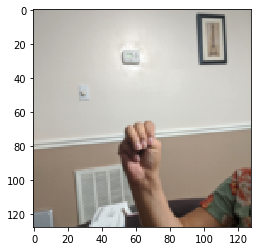

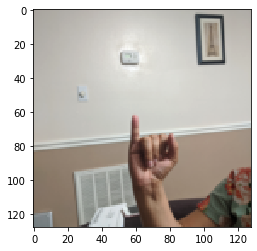

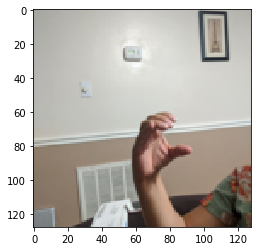

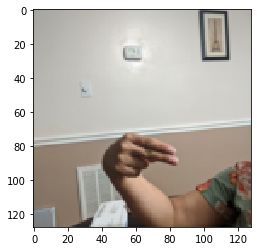

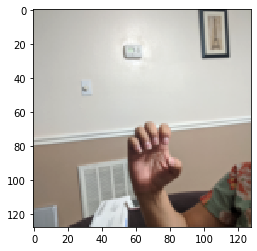

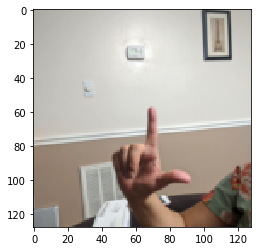

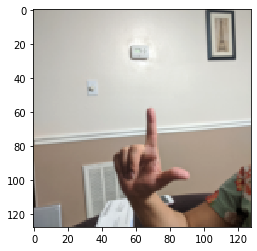

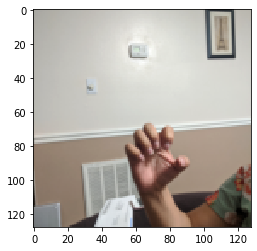

In [0]:
for x, y in michelle_loader:
  show_imgs(x)


# SSH Access

If ssh_connect is True, an ssh server will be set up on the hosting server. Ergo power.

In [0]:
ssh_connect = False
if ssh_connect:
  import random, string, getpass

  password = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(20))
  alias = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(8))
  ! echo root:$password | chpasswd

  ! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
  ! mkdir -p /var/run/sshd
  ! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config && echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
  ! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc && echo "export LD_LIBRARY_PATH" >> /root/.bashrc
  get_ipython().system_raw('/usr/sbin/sshd -D &')

  print('sshpass -p {} ssh -o "StrictHostKeyChecking no" -J serveo.net root@{}'.format(password, alias))
  ! ssh -o "StrictHostKeyChecking no" -R $alias:22:localhost:22 serveo.net